# Classification of Sign-Languag-MNIST Using Conv-NeXt

## Setting Up Environment and Dependencies

Initially tried setting up a conda environment but ran into errors with activation of venv as colab shell does not support this task well. Upon doing research, found that using 'pip' to create an enviornemnt and install packages is usually sufficient for any task on colab.

In [1]:
!pip3 install timm==0.5.4
!pip install Pillow
!pip install optuna
!pip install -U accelerate
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 96.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import csv
from typing import List
import timm
from timm import create_model
import math
import seaborn as sns
from torch.utils.data import random_split
from PIL import Image
import optuna
from optuna.trial import TrialState
from datetime import datetime
import transformers
import accelerate
from transformers import ViTForImageClassification
from transformers import TrainingArguments, Trainer, TrainerCallback

In [3]:
transformers.__version__, accelerate.__version__

('4.35.2', '0.24.1')

In [4]:
# Mounting Drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Helper functions
def save_model(model, file_path):
    """
    Save a PyTorch model to a file.

    Args:
        model: The PyTorch model to be saved.
        file_path: The file path where the model will be saved: (model.pth)
    """
    try:
        now = datetime.now().strftime("%Y%m%d_%H%M%S")
        torch.save(model.state_dict(), f"{file_path}_{now}.pt")
        print(f"Model saved to {file_path}")
    except Exception as e:
        print(f"An error occurred while saving the model: {str(e)}")

def load_model(file_path, model):
    """
    Load a PyTorch model from a file.

    Args:
        file_path: The base file path for the model (excluding the timestamp and extension).
        model: An instance of the model (with the same architecture as the saved model).

    Returns:
        The loaded model.
    """
    try:
        # List all files in the directory and find the one that matches the base file_path
        files = [f for f in os.listdir('.') if os.path.isfile(f)]
        model_files = [f for f in files if f.startswith(file_path) and f.endswith('.pt')]
        if not model_files:
            raise ValueError(f"No model files found starting with {file_path}")

        # Assuming you want the most recent model file
        latest_file = max(model_files, key=os.path.getctime)
        model.load_state_dict(torch.load(latest_file), strict=False)
        print(f"Model loaded from {latest_file}")

        return model

    except Exception as e:
        print(f"An error occurred while loading the model: {str(e)}")

        return None

def plot_and_save_losses(train_losses, val_losses, filename):
    """
    Plot training and validation losses and save the plot to a file.

    Args:
    - train_losses (list of float): List of training losses.
    - val_losses (list of float): List of validation losses.
    - filename (str): Filename to save the plot.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(filename)
    plt.show()


In [6]:
# Global Variables
MODEL_PATH = '/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model'
ISL = False

In [7]:
# For deterministic results
np.random.seed(42)

## Data Preprocessing

### Data Exploration

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/sign-language-MNIST/sign_mnist_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/sign-language-MNIST/sign_mnist_test.csv')

In [ ]:
# Shuffle train_df and test_df
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_df.iloc[:4,:10]

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9
0,3,122,131,140,149,153,157,160,165,170
1,19,125,133,140,146,151,152,156,160,165
2,3,130,138,143,146,149,151,153,155,156
3,22,92,97,102,105,109,111,114,115,117


In [ ]:
print(f'Number of images in the training set: {train_df.shape[0]}')
print(f'Number of images in the test set: {test_df.shape[0]}')

d = int((train_df.shape[1] - 1)**0.5)
print(f'Shape of the images: {d} x {d}')

Number of images in the training set: 27455
Number of images in the test set: 7172
Shape of the images: 28 x 28


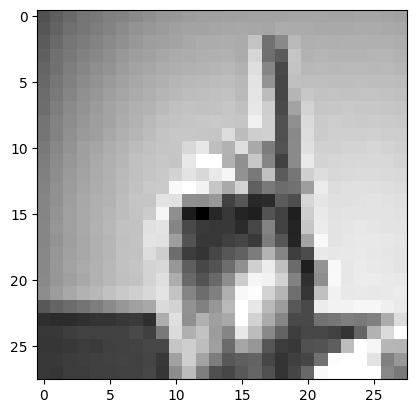

In [ ]:
def to_image(array, label = True):
    # Reshape an array into an image format
    array = np.array(array)
    start_idx = 1 if label else 0
    return array[start_idx:].reshape(28,28).astype(float)

# Display one image
img = to_image(train_df.iloc[0])
plt.imshow(img, cmap = 'gray')
plt.show()

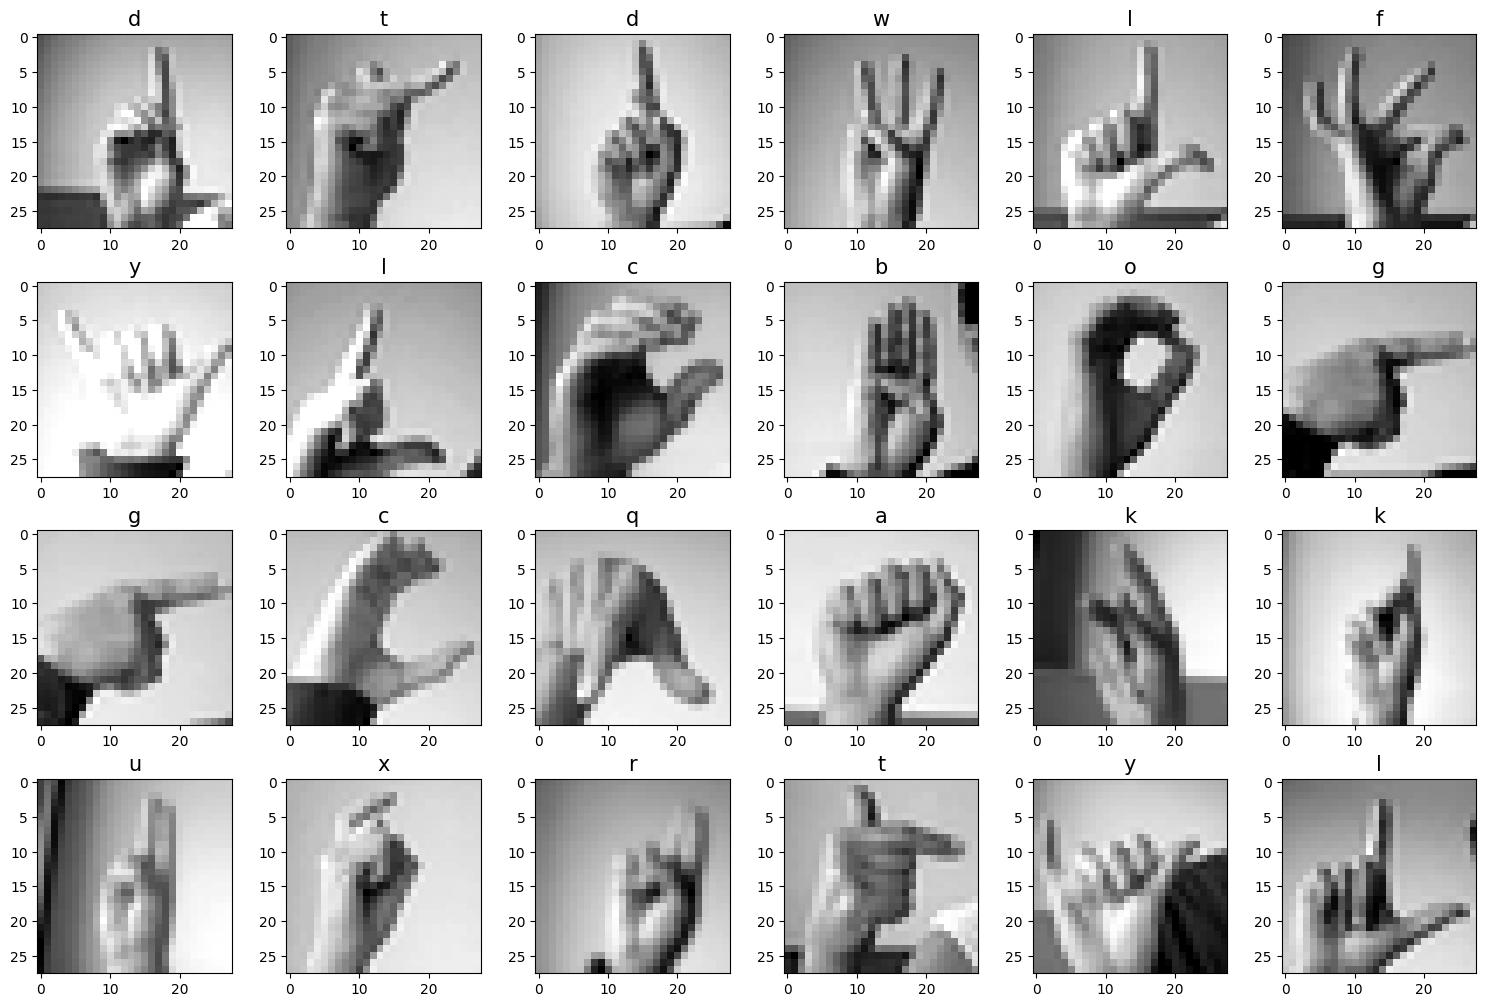

In [ ]:
# Creating mapping from numbers to letters
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {}

for i,l in enumerate(alphab):
    mapping_letter[l] = i
mapping_letter = {v:k for k,v in mapping_letter.items()}

# Displaying a few images
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    img = to_image(train_df.iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = mapping_letter[train_df.label[i]]
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

<ipython-input-10-d72d2014d188>:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Counts')


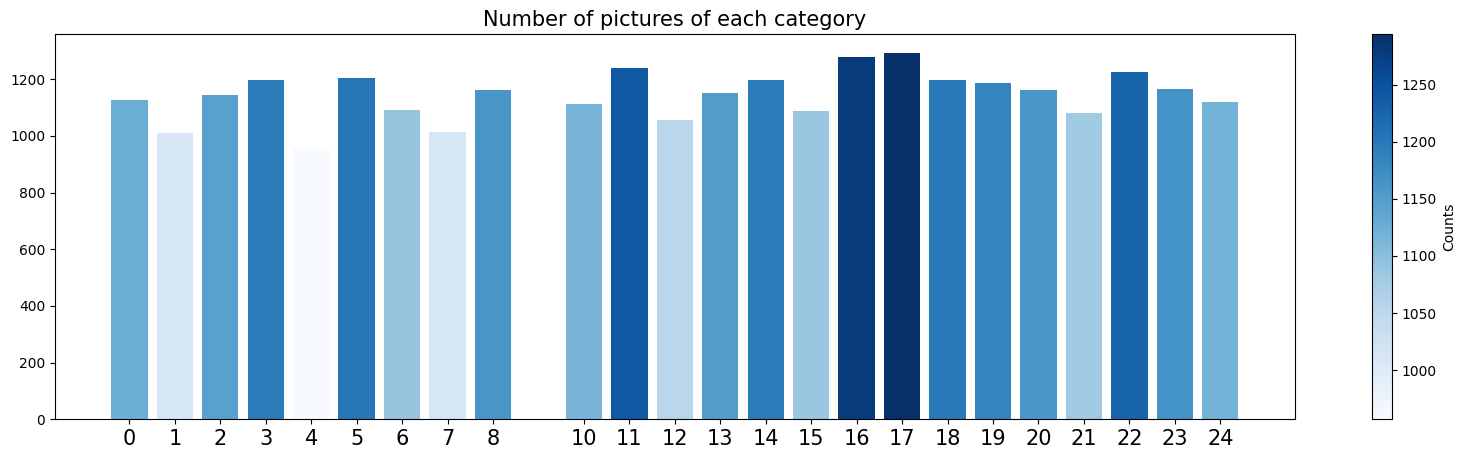

In [ ]:
# Display the number of pictures of each letter
vc = train_df['label'].value_counts()
norm = plt.Normalize(vc.min(), vc.max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
plt.figure(figsize=(20,5))
bars = plt.bar(x=vc.index, height=vc, color=sm.to_rgba(vc))
plt.title("Number of pictures of each category", fontsize=15)
plt.xticks(vc.index, fontsize=15)
plt.colorbar(sm, label='Counts')
plt.show()

In [ ]:
# Outlier detection on train dataset
X = train_df.iloc[:, 1:].values
X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Apply PCA and retain the top k components
k = 50
pca = PCA(n_components=k)
X_pca = pca.fit_transform(X_normalized)

# Reconstruct the data from the top k components
X_reconstructed = pca.inverse_transform(X_pca)

reconstruction_error = np.mean((X_normalized - X_reconstructed) ** 2, axis=1)

threshold = np.percentile(reconstruction_error, 99)
outliers = np.where(reconstruction_error > threshold)[0]

print(f"Found {len(outliers)} potential outliers.")

# Should I clean the datatset?

NameError: ignored

### Data Augmentation

In [8]:
# Clean class to utilize sign-language-MNIST: https://www.digitalocean.com/community/tutorials/how-to-build-a-neural-network-to-translate-sign-language-into-english
class SignLanguageMNIST(Dataset):
    """Sign Language classification dataset.

    Utility for loading Sign Language dataset into PyTorch. Dataset posted on
    Kaggle in 2017, by an unnamed author with username `tecperson`:
    https://www.kaggle.com/datamunge/sign-language-mnist

    Each sample is 1 x 1 x 28 x 28, and each label is a scalar.
    """

    @staticmethod
    def get_label_mapping():
        """
        We map all labels to [0, 23]. This mapping from dataset labels [0, 23]
        to letter indices [0, 25] is returned below.
        """
        mapping = list(range(25))
        mapping.pop(9)
        return mapping

    @staticmethod
    def read_label_samples_from_csv(path: str, model):
        """
        Assumes first column in CSV is the label and subsequent 28^2 values
        are image pixel values 0-255.
        """
        mapping = SignLanguageMNIST.get_label_mapping()
        labels, samples = [], []
        with open(path) as f:
            _ = next(f)  # skip header
            for line in csv.reader(f):
                label = int(line[0])
                labels.append(mapping.index(label))
                samples.append(list(map(int, line[1:])))

        # Binarizing the labels for the ConvNeXt model
        if model == "ConvNeXt":
            label_binarizer = LabelBinarizer()
            labels = label_binarizer.fit_transform(labels)

        # Getting mean and std
        samples = np.array(samples, dtype=np.uint8) # Should I divide by 255 here?
        mean = np.mean(samples)
        std = np.std(samples)

        return labels, samples, mean, std

    def __init__(self, path, model="ConvNeXt"):
        """
        Args:
            path: Path to `.csv` file containing `label`, `pixel0`, `pixel1`...
        """
        labels, samples, mean, std = SignLanguageMNIST.read_label_samples_from_csv(path, model)
        self._samples = np.array(samples, dtype=np.uint8).reshape((-1, 28, 28, 1))
        self._labels = np.array(labels, dtype=np.uint8)
        # print(self._labels.shape)
        # print(self._samples.shape)
        self._mean = mean
        self._std = std
        self.model = model

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
      transform = transforms.Compose([
          transforms.ToPILImage(),
          transforms.Lambda(lambda x: x.convert("RGB")),
          # transforms.RandomResizedCrop(28, scale=(0.8, 1.2)),
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          ])

      transformed_sample = transform(self._samples[idx]).float()
      if self.model == "ConvNeXt":
          label_tensor = torch.from_numpy(self._labels[idx]).float()
      else:
          label_tensor = torch.tensor(self._labels[idx], dtype=torch.long)

      return {
          'pixel_values': transformed_sample,
          'labels': label_tensor
      }


In [9]:
# Loading data
batch_size = 32

trainset = SignLanguageMNIST('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/sign-language-MNIST/sign_mnist_train.csv')

# 80/20 split
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

testset = SignLanguageMNIST('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/sign-language-MNIST/sign_mnist_test.csv')
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
def print_sample_idx(idx, dataloader):
  data_iter = iter(dataloader)

  # Get the first batch
  first_batch = next(data_iter)

  # Extract the first sample and label from the batch
  first_sample = first_batch['pixel_values'][idx]
  plt.imshow(first_sample.permute(1, 2, 0))
  plt.show()
  first_label = first_batch['labels'][idx]

  # Print the first sample and label
  print("First Sample:", first_sample)
  print("First Label:", first_label)
  print("First Sample shape:", first_sample.shape)
  print("First Label shape:", first_label.shape)

  print(first_sample[0, :, :])
  #print(first_sample[1, :, :])
  #print(first_sample[2, :, :])

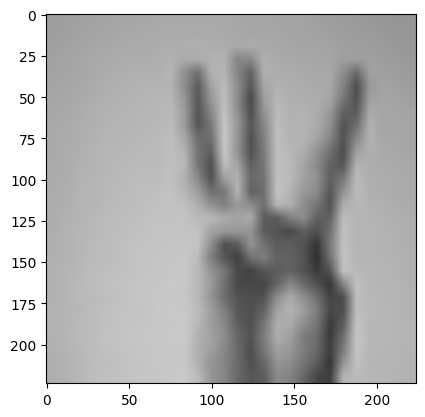

First Sample: tensor([[[0.6196, 0.6196, 0.6196,  ..., 0.5843, 0.5843, 0.5843],
         [0.6196, 0.6196, 0.6196,  ..., 0.5843, 0.5843, 0.5843],
         [0.6196, 0.6196, 0.6196,  ..., 0.5843, 0.5843, 0.5843],
         ...,
         [0.6824, 0.6824, 0.6824,  ..., 0.6980, 0.6980, 0.6980],
         [0.6824, 0.6824, 0.6824,  ..., 0.6980, 0.6980, 0.6980],
         [0.6824, 0.6824, 0.6824,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6196, 0.6196, 0.6196,  ..., 0.5843, 0.5843, 0.5843],
         [0.6196, 0.6196, 0.6196,  ..., 0.5843, 0.5843, 0.5843],
         [0.6196, 0.6196, 0.6196,  ..., 0.5843, 0.5843, 0.5843],
         ...,
         [0.6824, 0.6824, 0.6824,  ..., 0.6980, 0.6980, 0.6980],
         [0.6824, 0.6824, 0.6824,  ..., 0.6980, 0.6980, 0.6980],
         [0.6824, 0.6824, 0.6824,  ..., 0.6980, 0.6980, 0.6980]],

        [[0.6196, 0.6196, 0.6196,  ..., 0.5843, 0.5843, 0.5843],
         [0.6196, 0.6196, 0.6196,  ..., 0.5843, 0.5843, 0.5843],
         [0.6196, 0.6196, 0.6196,  ..., 0.58

In [ ]:
print_sample_idx(0, trainloader)

## Base Model Predictions

In [9]:
print(timm.list_models())

['adv_inception_v3', 'bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_224_in22k', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_224_in22k', 'beit_large_patch16_384', 'beit_large_patch16_512', 'botnet26t_256', 'botnet50ts_256', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_tiny', 'convit_base', 'convit_small', 'convit_tiny', 'convmixer_768_32', 'convmixer_1024_20_ks9_p14', 'convmixer_1536_20', 'convnext_base', 'convnext_base_384_in22ft1k', 'convnext_base_in22ft1k', 'convnext_base_in22k', 'convnext_large', 'convnext_large_384_in22ft1k', 'convnext_large_in22ft1k', 'convnext_large_in22k', 'convnext_small', 'convnext_tiny', 'convnext_tiny_hnf', 'convnext_xlarge_384_in22ft1k', 'convnext_xlarge_in22ft1k', 'convnext_xlarge_in22k', 'crossvit_9_240', 'crossvit_9_d

In [16]:
model_name = 'convnext_tiny'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ConvNeXt model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/convnext.py
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


In [ ]:
def modifyHead(model, num_classes):
  # Disable gradients on all model parameters to freeze the weights
  for param in model.parameters():
      param.requires_grad = False

  # Replace the final fully connected layer
  global_pool = model.head.global_pool
  norm = model.head.norm
  flatten = model.head.flatten
  drop = model.head.drop
  fc = model.head.fc

  class ModifiedHead(nn.Module):
      def __init__(self, out_features):
          super(ModifiedHead, self).__init__()
          self.global_pool = global_pool
          self.norm = norm
          self.flatten = flatten
          self.drop = drop

          self.relu = nn.ReLU()

          self.fc = nn.Linear(in_features=768, out_features=out_features, bias=True)
          self.log_softmax = nn.LogSoftmax(dim=1)

      def forward(self, x):
          x = self.global_pool(x)
          x = self.norm(x)
          x = self.flatten(x)
          x = self.drop(x)
          x = self.relu(x)
          x = self.fc(x)
          x = self.log_softmax(x)
          return x

  model.head = ModifiedHead(num_classes)

  for param in model.head.parameters():
      param.requires_grad = True

  # Unfreeze the last stage
  for param in model.stages[3].parameters():
      param.requires_grad = True

  return model

In [ ]:
model = modifyHead(model, 24)

In [ ]:
print(model)

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, 

In [ ]:
# Accessing intermediary layer of model
ConvNeXt_block_0 = model.stages[0].blocks[0]
print(ConvNeXt_block_0)

ConvNeXtBlock(
  (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
  (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
  (mlp): Mlp(
    (fc1): Linear(in_features=96, out_features=384, bias=True)
    (act): GELU(approximate='none')
    (drop1): Dropout(p=0.0, inplace=False)
    (fc2): Linear(in_features=384, out_features=96, bias=True)
    (drop2): Dropout(p=0.0, inplace=False)
  )
  (drop_path): Identity()
)


In [ ]:
model = model.to(device)

In [ ]:
# Training Loop
def train_and_eval(params, model, train_dataset, val_dataset, save_path, name):
  train_losses, val_losses, val_accuracy = [], [], []
  batch_size = params['batch_size']
  learning_rate = params['learning_rate']

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.NLLLoss()

  trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  for epoch in range(5): # 5 epochs fo training
      model.train()
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          if not ISL:
              inputs, labels = data['pixel_values'].to(device), torch.argmax(data['labels'], dim=1).long().to(device)  # Convert one-hot encoded labels to class indices
          else:
              inputs, labels = data['pixel_values'].to(device), data['labels'].long().to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
          if i % 100 == 99:  # print every 100 mini-batches
              _, predicted_classes = outputs.max(dim=1)
              # print(predicted_classes, labels)
              print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
              running_loss = 0.0

      # Average training loss for the epoch
      avg_train_loss = running_loss / len(trainloader)
      train_losses.append(avg_train_loss)

      # Evaluate on the validation set
      model.eval()
      val_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
          for data in valloader:
              if not ISL:
                  inputs, labels = data['pixel_values'].to(device), torch.argmax(data['labels'], dim=1).long().to(device)  # Convert one-hot encoded labels to class indices
              else:
                  inputs, labels = data['pixel_values'].to(device), data['labels'].long().to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = outputs.max(1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      # Average validation loss for the epoch
      avg_val_loss = val_loss / len(valloader)
      val_losses.append(avg_val_loss)

      accuracy = correct / total
      val_accuracy.append(accuracy)

      print(f"Epoch {epoch+1}/{5}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Accuracy: {accuracy}")

      # Save model weights
      torch.save(model.state_dict(), os.path.join(save_path, f'{name}_weights_epoch_{epoch+1}.pth'))

      # Save training and validation losses
      with open(os.path.join(save_path, f'{name}_losses_epoch_{epoch+1}.txt'), 'w') as f:
          f.write(f'Training Loss: {avg_train_loss}\n')
          f.write(f'Validation Loss: {avg_val_loss}\n')

  return train_losses, val_losses, val_accuracy


In [ ]:
params = {
    'batch_size': 64,
    'learning_rate': 0.0026623878739691644,
}
save_path = '/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Logs/ConvNeXt/'

train_loss, val_loss, val_accuracy = train_and_eval(params, model, train_dataset, val_dataset, save_path, 'ConvNeXt-Tuned')
print(val_accuracy)

[1, 100] loss: 0.083
[1, 200] loss: 0.048
[1, 300] loss: 0.010
Epoch 1/5, Training Loss: 0.0008781582855907652, Validation Loss: 0.00043723736167140847, Accuracy: 0.9998178838098707
[2, 100] loss: 0.018
[2, 200] loss: 0.038
[2, 300] loss: 0.002
Epoch 2/5, Training Loss: 4.35623695032751e-06, Validation Loss: 2.058111799352594e-05, Accuracy: 1.0
[3, 100] loss: 0.000
[3, 200] loss: 0.000
[3, 300] loss: 0.000
Epoch 3/5, Training Loss: 6.675414827211255e-07, Validation Loss: 6.0170387150508255e-06, Accuracy: 1.0
[4, 100] loss: 0.000
[4, 200] loss: 0.000
[4, 300] loss: 0.000
Epoch 4/5, Training Loss: 1.9552260668401793e-07, Validation Loss: 2.919326940559057e-06, Accuracy: 1.0
[5, 100] loss: 0.000
[5, 200] loss: 0.000
[5, 300] loss: 0.000
Epoch 5/5, Training Loss: 1.3771368591223067e-07, Validation Loss: 1.9374661493138986e-06, Accuracy: 1.0
[0.9998178838098707, 1.0, 1.0, 1.0, 1.0]


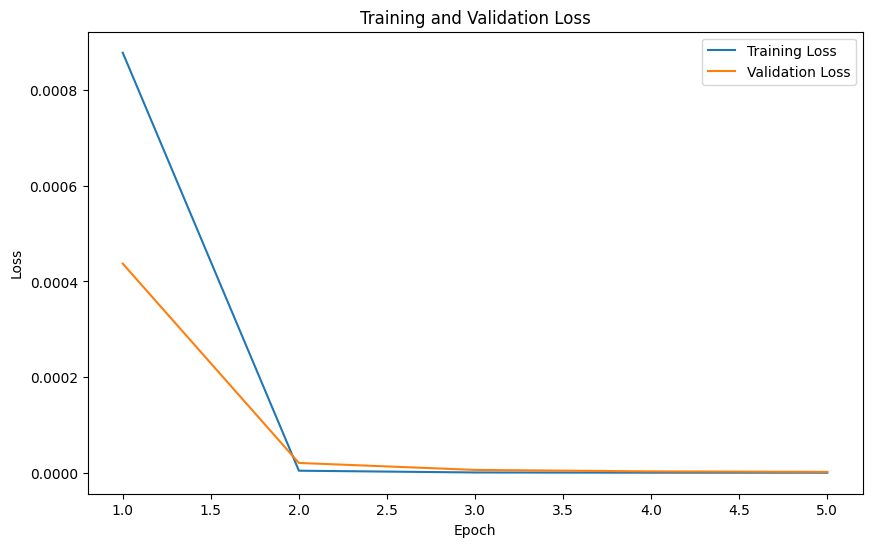

In [ ]:
plot_and_save_losses(train_loss, val_loss, '/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ConvNeXt/ConvNeXt-Tuned')

In [ ]:
# Hyperparameter tuning using Optuna
def objectiveConvNeXt(trial):
    if not ISL:
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    else:
        batch_size = trial.suggest_categorical('batch_size', [1, 4, 8, 16])

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    params = {
        'batch_size': batch_size,
        'learning_rate': learning_rate,
    }

    if not ISL:
        model_name = 'convnext_tiny'
        model = create_model(model_name, pretrained=True)
        model = modifyHead(model, 24)
        model = model.to(device)
    else:
        model_name = 'convnext_tiny'
        model = create_model(model_name, pretrained=True)
        model = modifyHead(model, 23)
        state_dict = torch.load('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ConvNeXt/_20231113_210621.pt')
        state_dict = {k: v for k, v in state_dict.items() if 'head.fc' not in k}
        model.load_state_dict(state_dict, strict=False)
        model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(5):
        model.train()
        for i, data in enumerate(trainloader, 0):
            if not ISL:
                inputs, labels = data['pixel_values'].to(device), torch.argmax(data['labels'], dim=1).long().to(device)
            else:
                inputs, labels = data['pixel_values'].to(device), data['labels'].long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    total = correct = 0
    with torch.no_grad():
        for data in valloader:
            if not ISL:
                inputs, labels = data['pixel_values'].to(device), torch.argmax(data['labels'], dim=1).long().to(device)
            else:
                inputs, labels = data['pixel_values'].to(device), data['labels'].long().to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objectiveConvNeXt, n_trials=10)
print(study.best_trial)

best_params = study.best_trial.params
print(f"Best trial hyperparameters: {best_params}")

In [ ]:
save_model(model, "/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ConvNeXt/")

Model saved to /content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ConvNeXt/


## Class Activation Maps

In [ ]:
print(model.stages[3].blocks)

Sequential(
  (0): ConvNeXtBlock(
    (conv_dw): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=768)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate='none')
      (drop1): Dropout(p=0.0, inplace=False)
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (drop_path): Identity()
  )
  (1): ConvNeXtBlock(
    (conv_dw): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=768)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate='none')
      (drop1): Dropout(p=0.0, inplace=False)
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (drop_path): Ident

In [ ]:
def generate_cam(model, image, target_class):
    '''
    Generate the class activation maps for a given image and target class.

    Args:
    - model: Trained PyTorch model
    - image: Input tensor of shape (batch_size, C, H, W)
    - target_class: Target class index
    - last_conv_name: Name of the last convolutional layer in the model
    - fc_name: Name of the final fully connected layer (output layer)

    Returns:
    - cam: Class activation map tensor of shape (H, W)
    '''

    # Get the features from the last convolutional layer
    model.eval()
    activations = None
    def hook_fn(module, input, output):
        nonlocal activations
        activations = output.detach().cpu()
    hook = model.stages[3].blocks[2].conv_dw.register_forward_hook(hook_fn)
    outputs = model(image)
    hook.remove()

    # Get the weights from the fully connected layer for the target class
    fc_weights = model.head.fc.weight.detach().cpu().numpy()
    target_weights = torch.tensor(fc_weights[target_class])

    # Compute the class activation map
    # print(activations.shape)
    # print(target_weights.shape)
    cam = (activations * target_weights[:, None, None]).sum(dim=1).squeeze().detach().cpu()


    # Upsample to image size
    cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(image.shape[2], image.shape[3]), mode='bilinear').squeeze()

    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    return cam

def display_cam_on_image(image, cam, filename):
    image = image[0].detach().cpu().numpy().transpose(1, 2, 0)
    cam = cam.numpy()

    plt.imshow(image, cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')

    plt.savefig(filename)
    plt.show()

## Testing

In [ ]:
# Testing
correct_total = 0
total_samples = 0
class_correct = [0.0] * 24
class_total = [0.0] * 24
total_batches = math.ceil(len(testset) / batch_size)

# Initialize confusion matrix
confusion_matrix = np.zeros((24, 24))

with torch.no_grad():
    for idx, data in enumerate(testloader):
        if idx % 20 == 19:  # print every 20 mini-batches
            print(f"Batch {idx} of {total_batches}.")

        images = data['pixel_values'].to(device)
        # print(images.shape)

        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(data['labels'], dim=1).long().to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct = (predicted == labels).squeeze()
        batch_size_actual = labels.size(0)

        for i in range(batch_size_actual):
            # For misclassification
            if not (labels[i] == predicted[i]):
                  plt.imshow(images[i].cpu().permute(1, 2, 0))
                  plt.savefig(f"/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ConvNeXt/{labels[i].item()}")
                  plt.show()
                  input = images[i].unsqueeze(0)
                  print(f"Real CAM: class {labels[i].item()}")
                  cam = generate_cam(model, input, labels[i].item())
                  display_cam_on_image(input, cam, f"/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ConvNeXt/ConvNeXt-Tuned_true_{labels[i].item()}")
                  print(f"Predicted CAM: class {predicted[i].item()}")
                  cam = generate_cam(model, input, predicted[i].item())
                  display_cam_on_image(input, cam, f"/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ConvNeXt/ConvNeXt-Tuned_predicted_{predicted[i].item()}")
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            confusion_matrix[label.item()][predicted[i].item()] += 1

        correct_total += correct.sum().item()
        total_samples += batch_size_actual

# Calculate the overall accuracy
overall_accuracy = 100.0 * correct_total / total_samples

# Calculate class-wise accuracy
class_accuracies = [100.0 * class_correct[i] / class_total[i] for i in range(24)]

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
for i, acc in enumerate(class_accuracies):
    print(f"Accuracy of Class {i}: {acc:.2f}%")

# Display confusion matrix
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
            'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=alphabet, yticklabels=alphabet)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ConvNeXt/ConvNeXt_SLMNIST_confusion_matrix")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Comparing to ViT

In [10]:
# Loading datasets
trainset = SignLanguageMNIST('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/sign-language-MNIST/sign_mnist_train.csv', model="ViT")

# 80/20 split
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

test_dataset = SignLanguageMNIST('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/sign-language-MNIST/sign_mnist_test.csv', model="ViT")

In [11]:
classes = [chr(i) for i in range(65, 91) if i not in (74, 90)]
id2label = {i: classes[i] for i in range(24)}
label2id = {classes[i]: i for i in range(24)}

In [18]:
# Loading model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
state_dict = torch.load('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ViT/ASL_tuned_20231114_002401.pt')

model.load_state_dict(state_dict, strict=False)

model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [13]:
# Defining Trainer
metric_name = "accuracy"

args = TrainingArguments(
    f"/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ViT",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=0.00034635383454258124,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Logs/ViT',
    remove_unused_columns=False,
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return dict(accuracy=accuracy_score(predictions, labels))

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [14]:
# Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.176283,0.046258
2,3.174200,2.932446,0.107995
3,2.797800,2.144181,0.274085
4,2.797800,1.311624,0.574030
5,1.580800,0.650116,0.835731


TrainOutput(global_step=1720, training_loss=2.2932856537574944, metrics={'train_runtime': 4033.0951, 'train_samples_per_second': 27.23, 'train_steps_per_second': 0.426, 'total_flos': 8.511848326695813e+18, 'train_loss': 2.2932856537574944, 'epoch': 5.0})

In [16]:
train_loss, val_loss = [], []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        train_loss.append(elem['loss'])
    if 'eval_loss' in elem.keys():
        val_loss.append(elem['eval_loss'])

train_loss = [3.74] + train_loss
train_loss = train_loss[:2] + [2.797800] + train_loss[2:]
print(train_loss)
print(val_loss)


[3.74, 3.1742, 2.7978, 2.7978, 1.5808]
[3.176283121109009, 2.932445526123047, 2.1441805362701416, 1.3116240501403809, 0.6501160264015198]


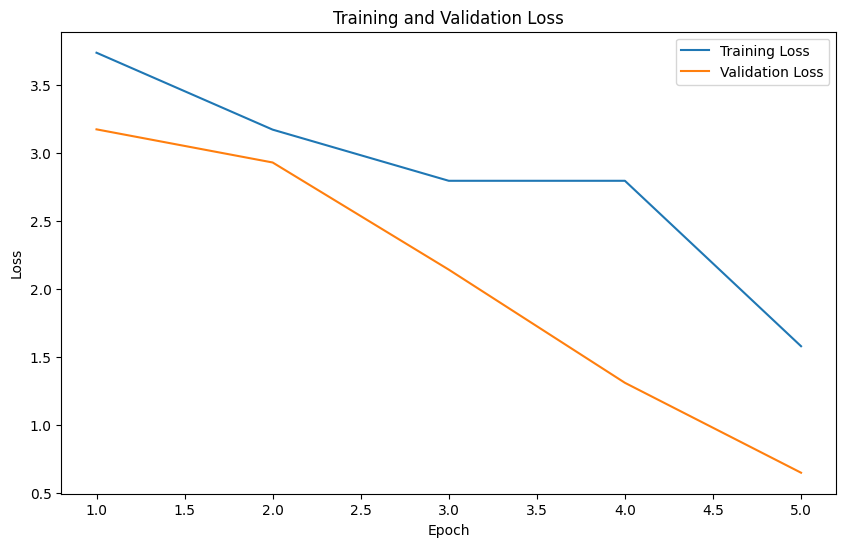

In [17]:
# Plotting
plot_and_save_losses(train_loss, val_loss, '/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ViT/ViT-Tuned')

In [16]:
# Hyperparameter Tuning using Optuna
def objectiveViT(trial):
    metric_name = "accuracy"

    if not ISL:
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    else:
        batch_size = trial.suggest_categorical('batch_size', [1, 4, 8, 16])

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)

    if not ISL:
        classes = [chr(i) for i in range(65, 91) if i not in (74, 90)]
        id2label = {i: classes[i] for i in range(24)}
        label2id = {classes[i]: i for i in range(24)}
        model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                    id2label=id2label,
                                                    label2id=label2id)
    else:
        classes = [chr(i) for i in range(65, 91) if i not in (72, 74, 89)]
        id2label = {i: classes[i] for i in range(len(classes))}
        label2id = {classes[i]: i for i in range(len(classes))}

        model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                          id2label=id2label,
                                                          label2id=label2id)

        state_dict = torch.load('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ViT/_20231114_002401.pt')

        state_dict = {k: v for k, v in state_dict.items() if 'classifier' not in k}

        model.load_state_dict(state_dict, strict=False)

    args = TrainingArguments(
        output_dir='/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ViT/Tuning',
        save_strategy="epoch",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,  # Assuming same batch size for evaluation
        num_train_epochs=5,
        load_best_model_at_end=True,
        metric_for_best_model=metric_name,
        logging_dir='/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Logs/ViT',
        remove_unused_columns=False,
        logging_steps=75
    )

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        return dict(accuracy=accuracy_score(predictions, labels))

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    eval_result = trainer.evaluate()

    return eval_result["eval_accuracy"]


In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objectiveViT, n_trials=5)

best_trial = study.best_trial
print(f"Best trial: {best_trial.params}")

[I 2023-11-14 10:02:43,228] A new study created in memory with name: no-name-7989f0c6-e6d9-4719-9efb-d7fad0d38288
<ipython-input-16-fe5a4acc1a89>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.182300,3.179581,0.042797
2,3.177500,3.178754,0.043162
3,3.177000,3.177256,0.040794
4,3.176200,3.177100,0.042797
5,3.176100,3.177774,0.042797


[I 2023-11-14 11:08:51,119] Trial 0 finished with value: 0.04316153706064469 and parameters: {'batch_size': 64, 'learning_rate': 0.004044683498206324}. Best is trial 0 with value: 0.04316153706064469.
<ipython-input-16-fe5a4acc1a89>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.052300,0.033678,1.000000
2,0.013100,0.011744,1.000000
3,0.007700,0.006827,1.000000
4,0.005300,0.005089,1.000000
5,0.004600,0.004599,1.000000


[I 2023-11-14 12:15:42,136] Trial 1 finished with value: 1.0 and parameters: {'batch_size': 64, 'learning_rate': 0.00015983391787897263}. Best is trial 1 with value: 1.0.
<ipython-input-16-fe5a4acc1a89>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.186900,3.186159,0.042797
2,3.179800,3.179989,0.043344
3,3.179100,3.181271,0.045347
4,3.175300,3.177733,0.042797
5,3.173200,3.177765,0.042797


[I 2023-11-14 13:25:00,413] Trial 2 finished with value: 0.04534693134219632 and parameters: {'batch_size': 16, 'learning_rate': 0.004800072768584826}. Best is trial 1 with value: 1.0.
<ipython-input-16-fe5a4acc1a89>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.059400,0.032429,0.995447
2,0.004500,0.003675,1.000000


[W 2023-11-14 13:58:43,684] Trial 3 failed with parameters: {'batch_size': 64, 'learning_rate': 0.00034635383454258124} because of the following error: FailedPreconditionError().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-16-fe5a4acc1a89>", line 63, in objectiveViT
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1555, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1922, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2257, in _maybe_log_save_evaluate
    self.log(logs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2645, in log
    self.control = s

FailedPreconditionError: ignored

In [18]:
save_model(model, "/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ViT/ASL_tuned")

Model saved to /content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ViT/ASL_tuned


In [30]:
# Displaying overlaid attention map on image
def display_attention_map(image, attention_map):
    if isinstance(attention_map, torch.Tensor):
        attention_map = attention_map.detach().cpu().numpy()

    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()

    resized_attention_map = np.array([np.array(Image.fromarray(channel).resize((224, 224), Image.BILINEAR))
                                       for channel in attention_map])

    resized_attention_map = np.mean(resized_attention_map, axis=0)

    normalized_attention_map = resized_attention_map / np.max(resized_attention_map)

    weighted_sum = np.sum(normalized_attention_map * image, axis=0)

    print(weighted_sum.shape)

    # Plot
    plt.imshow(weighted_sum)
    plt.axis('off')
    plt.show()



In [19]:
# Evaluation
outputs = trainer.predict(test_dataset)
print(outputs.metrics)

{'test_loss': 1.0901800394058228, 'test_accuracy': 0.6497490239821528, 'test_runtime': 98.1335, 'test_samples_per_second': 73.084, 'test_steps_per_second': 1.151}


Batch 19 of 225.
Predicted: class 6
(224, 224)


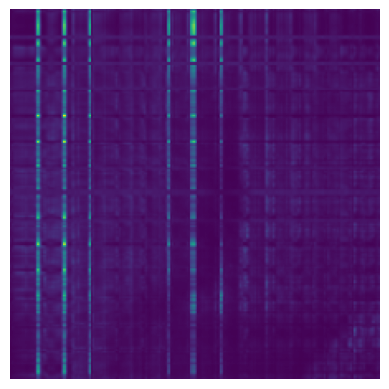

Batch 39 of 225.
Batch 59 of 225.
Batch 79 of 225.
Predicted: class 6
(224, 224)


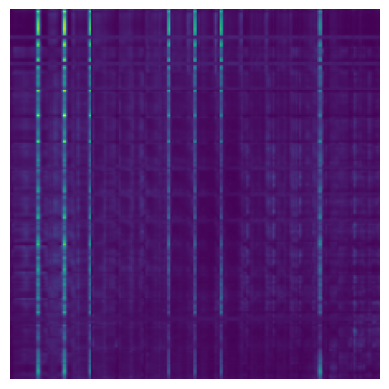

Batch 99 of 225.
Predicted: class 6
(224, 224)


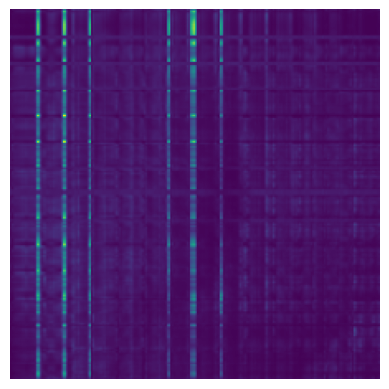

Batch 119 of 225.
Batch 139 of 225.
Batch 159 of 225.
Predicted: class 6
(224, 224)


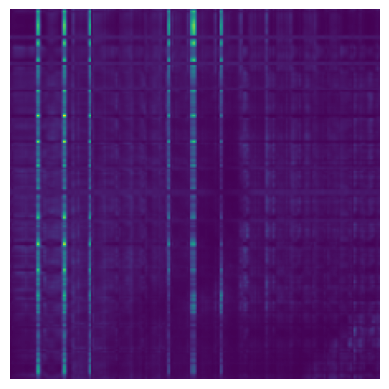

Batch 179 of 225.
Batch 199 of 225.
Predicted: class 6
(224, 224)


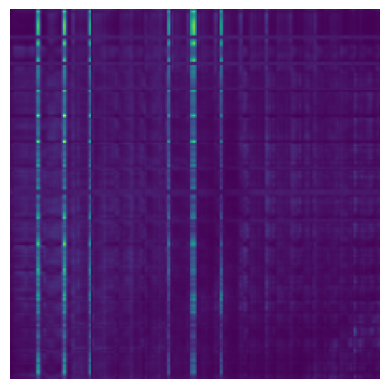

Batch 219 of 225.


In [31]:
# Another form of evaluation specifically for generating Attention Maps
total_batches = math.ceil(len(testset) / batch_size)
# Creating dataloader
testset = SignLanguageMNIST('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/sign-language-MNIST/sign_mnist_test.csv', model="ViT")
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

model.eval()
with torch.no_grad():
    for idx, data in enumerate(testloader):
        if idx % 20 == 19:  # print every 20 mini-batches
            print(f"Batch {idx} of {total_batches}.")

        images = data['pixel_values'].to(device)
        labels = data['labels'].to(device)

        outputs = model(images, output_attentions=True)
        predicted = outputs.logits.argmax(-1)

        correct = (predicted == labels).squeeze()
        batch_size_actual = labels.size(0)

        for i in range(batch_size_actual):
            # For misclassification
            if not (labels[i] == predicted[i]):
                  print(f"Predicted: class {labels[i].item()}")
                  # visualize_predict(images[i], 16, outputs.attentions[-1][i])
                  display_attention_map(images[i], outputs.attentions[-1][i])


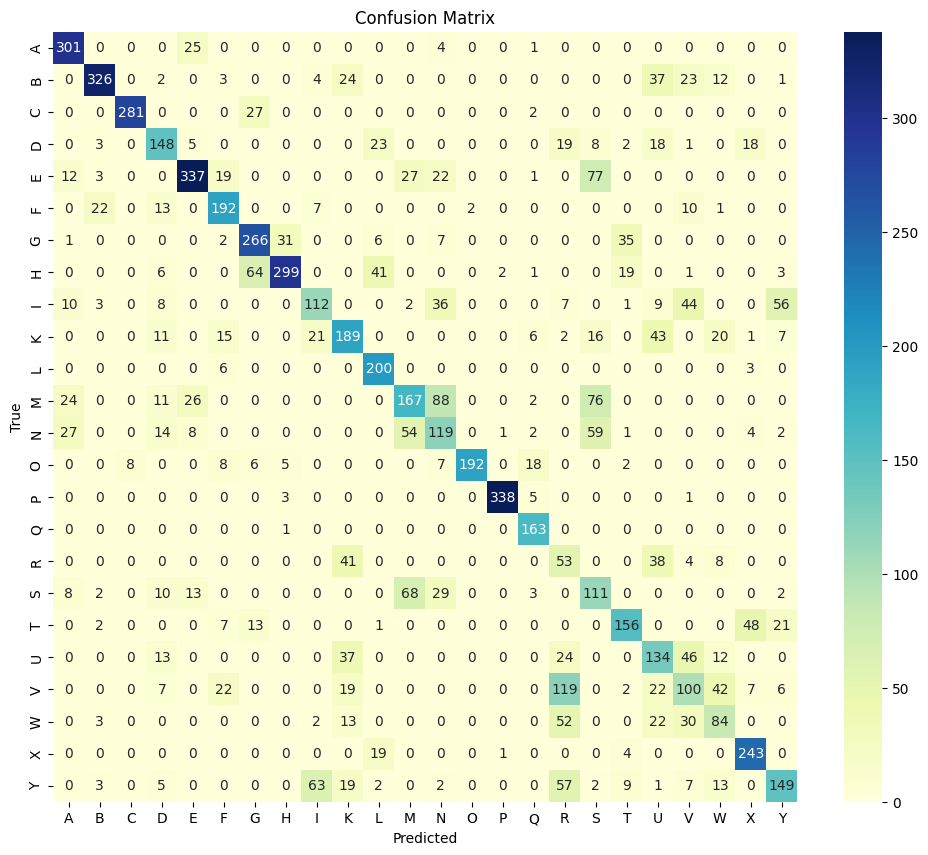

In [20]:
# Confusion matrix
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

confusion_matrix = np.zeros((24, 24))
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1

# Display confusion matrix
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
            'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=alphabet, yticklabels=alphabet)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ViT/ViT-Tuned_SLMNIST_confusion_matrix")
plt.show()

#### What to do with ISL dataset:

- 60/20/20 train/val/test split data
- save model for each epoch (checkpoint)


## Testing Generalization on ISL Dataset

In [158]:
# The dataset has been obtained from: https://www.kaggle.com/datasets/soumyakushwaha/indian-sign-language-dataset

# Class designed to load the data
class ISLDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return {"pixel_values": image, "labels": label}

def prepare_datasets(data_dir, transform):
    label_to_idx = {}
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}

    for label in sorted(os.listdir(data_dir)):
        if label not in ['H', 'J', 'Y']:
            class_dir = os.path.join(data_dir, label)
            images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
            train_imgs, test_imgs = train_test_split(images, test_size=0.4, random_state=42)
            val_imgs, test_imgs = train_test_split(test_imgs, test_size=0.5, random_state=42)

            label_idx = label_to_idx.setdefault(label, len(label_to_idx))

            for img_path in train_imgs:
                data['train'].append(img_path)
                labels['train'].append(label_idx)

            for img_path in val_imgs:
                data['val'].append(img_path)
                labels['val'].append(label_idx)

            for img_path in test_imgs:
                data['test'].append(img_path)
                labels['test'].append(label_idx)

    # Create ISLDataset instances
    train_dataset = ISLDataset(data['train'], labels['train'], transform=transform)
    val_dataset = ISLDataset(data['val'], labels['val'], transform=transform)
    test_dataset = ISLDataset(data['test'], labels['test'], transform=transform)

    return train_dataset, val_dataset, test_dataset

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset instances
train_dataset, val_dataset, test_dataset = prepare_datasets('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/ISL_Dataset/', transform)


### ConvNeXt

In [ ]:
ISL = True

In [ ]:
# Loading best ConvNeXt model
model_name = 'convnext_tiny'
model = create_model(model_name, pretrained=True)
model = modifyHead(model, 23)  # Modify head for 23 classes

state_dict = torch.load('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ConvNeXt/_20231113_210621.pt')

state_dict = {k: v for k, v in state_dict.items() if 'head.fc' not in k}

model.load_state_dict(state_dict, strict=False)
model = model.to(device)

In [ ]:
# Training
params = {
    'batch_size': 4,
    'learning_rate': 0.001518764141338299,
}
train_loss, val_loss, val_accuracy = train_and_eval(params, model, train_dataset, val_dataset, "/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Logs/ConvNeXt/", "ConvNext-Tuned-ISL")

[1, 100] loss: 0.599
Epoch 1/5, Training Loss: 0.012381647397013544, Validation Loss: 1.2507731883346827, Accuracy: 0.6453900709219859
[2, 100] loss: 0.223
Epoch 2/5, Training Loss: 0.005237339986759482, Validation Loss: 1.3313806508473742, Accuracy: 0.6453900709219859
[3, 100] loss: 0.164
Epoch 3/5, Training Loss: 0.00862674411494755, Validation Loss: 1.215502554900013, Accuracy: 0.7092198581560284
[4, 100] loss: 0.140
Epoch 4/5, Training Loss: 0.0001000188272988912, Validation Loss: 1.0965648609692127, Accuracy: 0.75177304964539
[5, 100] loss: 0.030
Epoch 5/5, Training Loss: 2.4125504406910497e-05, Validation Loss: 1.0004928366510688, Accuracy: 0.7588652482269503


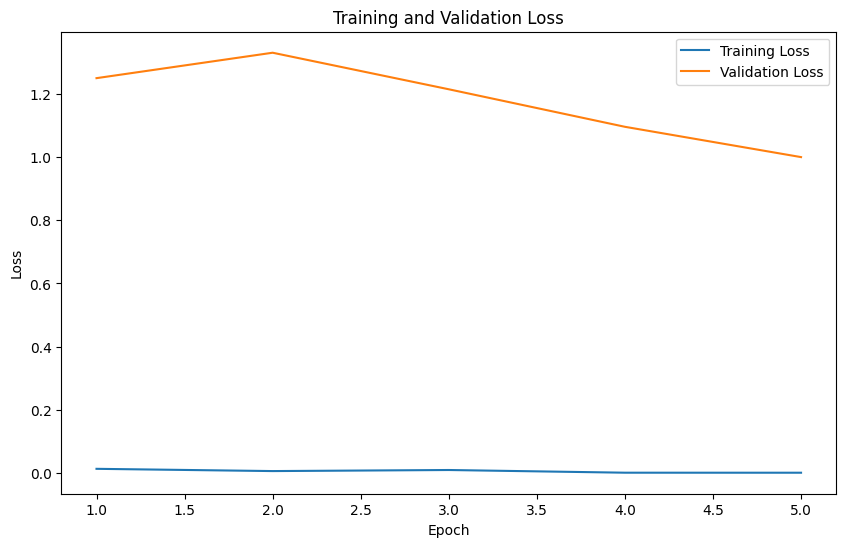

In [ ]:
# Plotting?
plot_and_save_losses(train_loss, val_loss, '/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ConvNeXt/ConvNeXt-Tuned-ISL')

In [ ]:
# Tuning
study = optuna.create_study(direction='maximize')
study.optimize(objectiveConvNeXt, n_trials=10)
print(study.best_trial)

best_params = study.best_trial.params
print(f"Best trial hyperparameters: {best_params}")

[I 2023-11-14 01:44:08,625] A new study created in memory with name: no-name-eeb6aad3-7c6b-43dd-9f30-fd823ab815e0
<ipython-input-112-19c771730c5e>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
[I 2023-11-14 01:44:51,197] Trial 0 finished with value: 0.3049645390070922 and parameters: {'batch_size': 1, 'learning_rate': 2.141675201257496e-05}. Best is trial 0 with value: 0.3049645390070922.
[I 2023-11-14 01:45:09,422] Trial 1 finished with value: 0.06382978723404255 and parameters: {'batch_size': 4, 'learning_rate': 0.035925225338846706}. Best is trial 0 with value: 0.3049645390070922.
[I 2023-11-14 01:45:24,239] Trial 2 finished with value: 0.06382978723404255 and parameters: {'batch_size': 8, 'learning_rate': 0.014959165023996742}. Best is trial 0 with val

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.7872340425531915], datetime_start=datetime.datetime(2023, 11, 14, 1, 46, 10, 764588), datetime_complete=datetime.datetime(2023, 11, 14, 1, 46, 28, 459450), params={'batch_size': 4, 'learning_rate': 0.001518764141338299}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'batch_size': CategoricalDistribution(choices=(1, 4, 8, 16)), 'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None)}, trial_id=4, value=None)
Best trial hyperparameters: {'batch_size': 4, 'learning_rate': 0.001518764141338299}


In [ ]:
save_model(model, "/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ConvNeXt/")

Model saved to /content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ConvNeXt/


In [150]:
model_name = 'convnext_tiny'
model = create_model(model_name, pretrained=True)
model = modifyHead(model, 23)  # Modify head for 23 classes

state_dict = torch.load('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ConvNeXt/_20231114_015806.pt')

model.load_state_dict(state_dict, strict=False)
model = model.to(device)

In [151]:
# Testing
correct_total = 0
total_samples = 0
class_correct = [0.0] * 23
class_total = [0.0] * 23
total_batches = math.ceil(len(test_dataset) / batch_size)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Initialize confusion matrix
confusion_matrix = np.zeros((23, 23))

with torch.no_grad():
    for idx, data in enumerate(test_loader):
        if idx % 20 == 19:  # print every 20 mini-batches
            print(f"Batch {idx} of {total_batches}.")

        images = data['pixel_values'].to(device)
        # print(images.shape)

        # Convert one-hot encoded labels to class indices
        labels = data['labels'].to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct = (predicted == labels).squeeze()
        batch_size_actual = labels.size(0)

        for i in range(batch_size_actual):
            # For misclassification
            if not (labels[i] == predicted[i]):
                  plt.imshow(images[i].cpu().permute(1, 2, 0))
                  plt.savefig(f"/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ConvNeXt/ISL_{labels[i].item()}")
                  plt.show()
                  input = images[i].unsqueeze(0)
                  print(f"Real CAM: class {labels[i].item()}")
                  cam = generate_cam(model, input, labels[i].item())
                  display_cam_on_image(input, cam, f"/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ConvNeXt/ConvNeXt-ISL-Tuned_true_{labels[i].item()}")
                  print(f"Predicted CAM: class {predicted[i].item()}")
                  cam = generate_cam(model, input, predicted[i].item())
                  display_cam_on_image(input, cam, f"/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ConvNeXt/ConvNeXt-ISL-Tuned_predicted_{predicted[i].item()}")
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            confusion_matrix[label.item()][predicted[i].item()] += 1

        correct_total += correct.sum().item()
        total_samples += batch_size_actual

# Calculate the overall accuracy
overall_accuracy = 100.0 * correct_total / total_samples

# Calculate class-wise accuracy
class_accuracies = [100.0 * class_correct[i] / class_total[i] for i in range(23)]

print(f"Overall Accuracy: {overall_accuracy:.2f}%")
for i, acc in enumerate(class_accuracies):
    print(f"Accuracy of Class {i}: {acc:.2f}%")

# Display confusion matrix
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L',
            'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Z']
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=alphabet, yticklabels=alphabet)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ConvNeXt/ConvNeXt_ISL_confusion_matrix")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### ViT

In [167]:
# Loading model
classes = [chr(i) for i in range(65, 91) if i not in (72, 74, 89)]
id2label = {i: classes[i] for i in range(len(classes))}
label2id = {classes[i]: i for i in range(len(classes))}

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

state_dict = torch.load('/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ViT/_20231114_002401.pt')

state_dict = {k: v for k, v in state_dict.items() if 'classifier' not in k}

model.load_state_dict(state_dict, strict=False)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=[])

In [168]:
# Defining Trainer
metric_name = "accuracy"

args = TrainingArguments(
    f"/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ViT/ISL",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=3.9269504280595505e-05,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Logs/ViT/ISL',
    remove_unused_columns=False,
    logging_steps=75
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return dict(accuracy=accuracy_score(predictions, labels))

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [169]:
# Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,3.150900,3.127474,0.049645
2,3.039100,2.899972,0.262411
3,2.336400,2.236381,0.659574
4,1.634100,1.758681,0.872340
5,1.294700,1.606866,0.886525


TrainOutput(global_step=2055, training_loss=2.3658974993257917, metrics={'train_runtime': 229.7574, 'train_samples_per_second': 8.944, 'train_steps_per_second': 8.944, 'total_flos': 1.5927601136735232e+17, 'train_loss': 2.3658974993257917, 'epoch': 5.0})

In [174]:
train_loss, val_loss = [], []
for elem in trainer.state.log_history:
    if 'loss' in elem.keys():
        train_loss.append(elem['loss'])
    if 'eval_loss' in elem.keys():
        val_loss.append(elem['eval_loss'])

# del train_loss[2]
train_loss = train_loss[::6]
print(train_loss)
print(val_loss)

[3.1337, 3.1456, 2.6659, 1.7483, 1.3138]
[3.127473831176758, 2.899972438812256, 2.2363812923431396, 1.7586807012557983, 1.606865644454956]


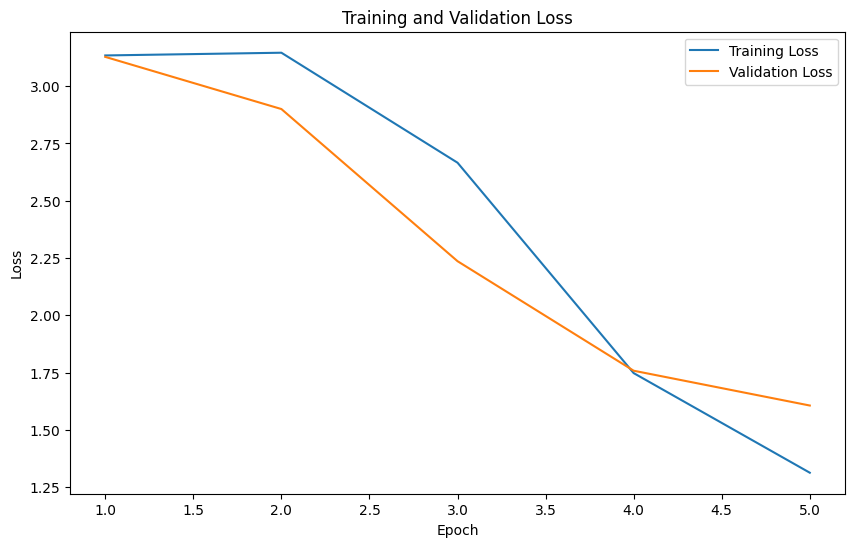

In [175]:
# Plotting
plot_and_save_losses(train_loss, val_loss, '/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ViT/ViT-ISL-Tuned')

In [164]:
study = optuna.create_study(direction='maximize')
study.optimize(objectiveViT, n_trials=10)

best_trial = study.best_trial
print(f"Best trial: {best_trial.params}")

[I 2023-11-14 04:20:59,166] A new study created in memory with name: no-name-19ba0fc6-b3a6-4920-9a20-4a7d75f354f8
<ipython-input-163-a4e992ca4879>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.761900,2.574489,0.524823
2,1.816800,1.651245,0.879433
3,1.019600,1.087123,0.936170
4,0.676300,0.835710,0.921986
5,0.524100,0.758116,0.929078


[I 2023-11-14 04:25:00,516] Trial 0 finished with value: 0.9361702127659575 and parameters: {'batch_size': 1, 'learning_rate': 3.9269504280595505e-05}. Best is trial 0 with value: 0.9361702127659575.
<ipython-input-163-a4e992ca4879>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.191500,3.285822,0.042553
2,3.173200,3.122011,0.063830
3,3.168200,3.129867,0.049645
4,3.173800,3.122349,0.056738
5,3.141300,3.124058,0.063830


[I 2023-11-14 04:29:22,437] Trial 1 finished with value: 0.06382978723404255 and parameters: {'batch_size': 1, 'learning_rate': 0.0024400378372515055}. Best is trial 0 with value: 0.9361702127659575.
<ipython-input-163-a4e992ca4879>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.957700,2.855913,0.361702
2,2.381100,2.395807,0.730496
3,1.859700,2.019858,0.829787
4,1.478800,1.795319,0.851064
5,1.287200,1.712908,0.865248


[I 2023-11-14 04:33:19,873] Trial 2 finished with value: 0.8652482269503546 and parameters: {'batch_size': 1, 'learning_rate': 2.1603028720773436e-05}. Best is trial 0 with value: 0.9361702127659575.
<ipython-input-163-a4e992ca4879>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,2.865000,2.718053,0.446809
2,2.082900,1.922025,0.808511
3,1.310100,1.356925,0.921986
4,0.894000,1.077691,0.914894
5,0.714700,0.986575,0.921986


[I 2023-11-14 04:37:22,140] Trial 3 finished with value: 0.9219858156028369 and parameters: {'batch_size': 1, 'learning_rate': 3.599337079930168e-05}. Best is trial 0 with value: 0.9361702127659575.
<ipython-input-163-a4e992ca4879>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.032500,2.959466,0.234043
2,2.657500,2.727681,0.482270
3,2.299900,2.533087,0.602837
4,1.999200,2.412921,0.680851
5,1.827100,2.367351,0.673759


[I 2023-11-14 04:41:16,312] Trial 4 finished with value: 0.6808510638297872 and parameters: {'batch_size': 1, 'learning_rate': 1.400653039783384e-05}. Best is trial 0 with value: 0.9361702127659575.
<ipython-input-163-a4e992ca4879>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.115500,2.908315,0.234043
2,2.831900,2.356965,0.687943
3,1.914800,1.904128,0.822695
4,1.493200,1.613015,0.865248
5,1.299400,1.522547,0.879433


[I 2023-11-14 04:43:42,320] Trial 5 finished with value: 0.8794326241134752 and parameters: {'batch_size': 4, 'learning_rate': 5.637807157716244e-05}. Best is trial 0 with value: 0.9361702127659575.
<ipython-input-163-a4e992ca4879>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.173508,0.056738
2,No log,3.120545,0.063830
3,3.166700,3.118538,0.063830
4,3.166700,3.118664,0.063830
5,3.166700,3.117583,0.063830


[I 2023-11-14 04:46:15,236] Trial 6 finished with value: 0.06382978723404255 and parameters: {'batch_size': 16, 'learning_rate': 0.003971807104277366}. Best is trial 0 with value: 0.9361702127659575.
<ipython-input-163-a4e992ca4879>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.200233,0.049645
2,No log,3.123642,0.063830
3,3.192300,3.121221,0.063830
4,3.192300,3.120626,0.056738
5,3.192300,3.117184,0.063830


[I 2023-11-14 04:48:29,348] Trial 7 finished with value: 0.06382978723404255 and parameters: {'batch_size': 16, 'learning_rate': 0.006855823822220076}. Best is trial 0 with value: 0.9361702127659575.
<ipython-input-163-a4e992ca4879>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,3.117500,2.976335,0.219858
2,2.886800,2.645711,0.531915
3,2.230600,2.349670,0.716312
4,1.892900,2.164162,0.773050
5,1.762500,2.096845,0.794326


[I 2023-11-14 04:51:13,537] Trial 8 finished with value: 0.7943262411347518 and parameters: {'batch_size': 4, 'learning_rate': 3.8506762687804155e-05}. Best is trial 0 with value: 0.9361702127659575.
<ipython-input-163-a4e992ca4879>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.067168,0.127660
2,3.048300,3.000926,0.184397
3,2.784800,2.956714,0.219858
4,2.784800,2.925853,0.276596
5,2.607400,2.914024,0.276596


[I 2023-11-14 04:53:41,172] Trial 9 finished with value: 0.2765957446808511 and parameters: {'batch_size': 8, 'learning_rate': 1.6753176707725062e-05}. Best is trial 0 with value: 0.9361702127659575.


Best trial: {'batch_size': 1, 'learning_rate': 3.9269504280595505e-05}


In [176]:
save_model(model, "/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ViT/")

Model saved to /content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Model/ViT/


In [177]:
# Evaluation
outputs = trainer.predict(test_dataset)
print(outputs.metrics)

{'test_loss': 1.627241611480713, 'test_accuracy': 0.8466666666666667, 'test_runtime': 4.555, 'test_samples_per_second': 32.931, 'test_steps_per_second': 32.931}


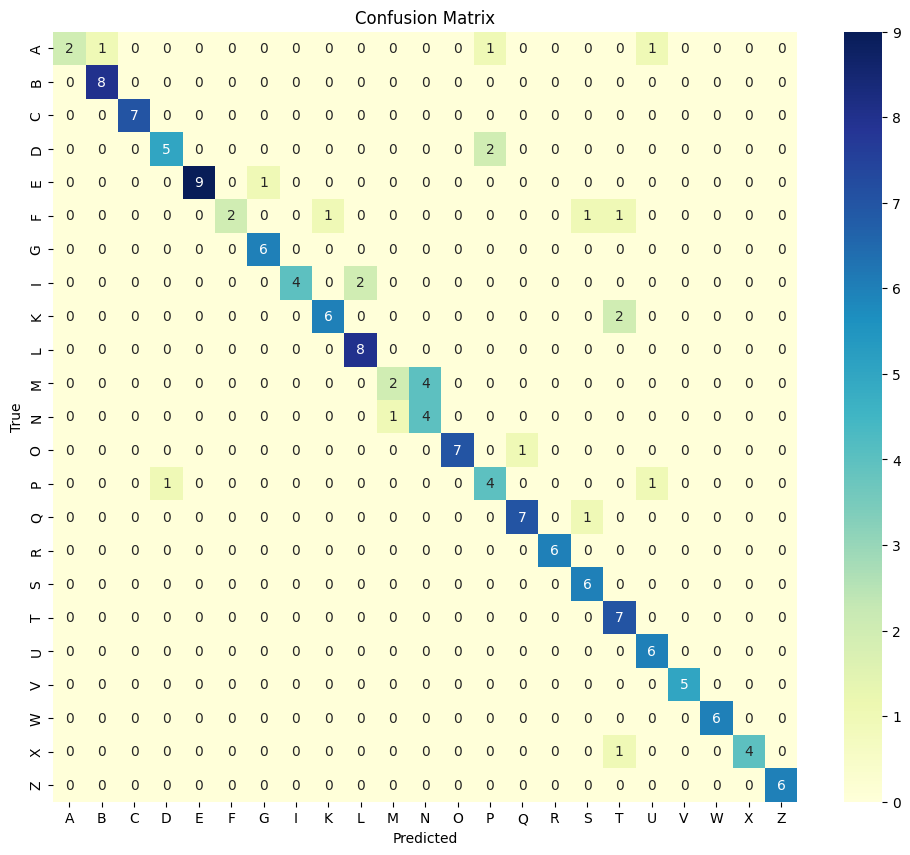

In [179]:
# Confusion matrix
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

confusion_matrix = np.zeros((23, 23))
for i in range(len(y_true)):
    confusion_matrix[y_true[i]][y_pred[i]] += 1

# Display confusion matrix
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L',
            'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Z']
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, cmap='YlGnBu', fmt='g',
            xticklabels=alphabet, yticklabels=alphabet)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("/content/drive/MyDrive/Lumiere_Aryaman_2023/Code/Data/Output/ViT/ViT-Tuned_ISL_confusion_matrix")
plt.show()

In [ ]:
ISL = False